# Методы стохастической оптимизации

## Метод имитации отжига (simulated annealing)

### Описание

Метод имитации отжига - это метод стохастической оптимизации, использующий упорядоченный случайный поиск на основе аналогии с процессом образования в веществе кристаллической структуры при охлаждении. Преимуществом метода отжига являются возможность избегать локальных минимумов оптимизируемой функции за счет принятия временно ухудшающих результат решений, что отражает суть процесса нагрева расплава для предотвращения его быстрого остывания. Метод отжига отличается от итеративных алгоритмов адаптивностью.

Метод отжига является одним из алгоритмов поиска глобального экстремума целевой функции $f(x)$, заданной для $x \in S$. Элементы множества $S$, дискретного или непрерывного, представляют собой состояния воображаемой физической системы("энергетические уровни"). Значение функции $f$ в этих точках используется как энергия системы $E = f(x)$. В каждый момент времени температура системы предполагается заданной. Находясь в состоянии с температурой $T$, следующее состояние системы выбирается в соответствии с заданным семейством вероятностных распределений $Q(x, T)$, которое задает новый случайный элемент $x^l = G(x, T)$. После генерации $x^l$ система с вероятностью $h(\Delta E; T)$ переходит к следующему шагу в следующее состояние $x^l$. Если этот переход не произошел, процесс генерации $x^l$ повторяется. Здесь $\Delta E$ обозначает приращение функции $f(x^l) - f(l)$

Конкретная схема отжига задается следующими параметрами:
* Выбором закона изменения температуры $T(k)$ на шаге $k$
* Выбором вероятностного распределения $Q(x; T)$
* Выбором функции вероятности принятия решения $h(\Delta E; T)$

В общем виде алгоритм можно представить в следующем виде:
1. Случайным образом выбирается начальная точка $x = x_0; x_0 \in S$. Текущее значение энергии $E$ устанавливается равным $f(x_0)$.
2. $k$-я итерация основного цикла состоит из шагов:
    * Сравнить энергию системы $E$ в состоянии $x$ с найденным на данный момент глобальным минимумом. Если $E = f(x)$ меньше, то изменить значение глобального минимума.
    * Сгенерировать новую точку $x^l = G(x; T(k))$.
    * Вычислить в ней значение $E^l = f(x^l)$.
    * Сгенерировать случайное число $\alpha \sim U[0;1]$
    * Если $\alpha < h(E^l - E; T(k))$, то:
    * * установить $x \longrightarrow x^l; E \longrightarrow E^l$
    * * Перейти к следующей итерации
    * Иначе, повторить процесс генерации

### Реализация (Python)

In [1]:
# импортируем все необходимое
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# задаем функцию изменения температуры
def decreaseTemperature(init_T, k, alpha):
    return init_T * alpha / k

In [3]:
# задаем функцию вероятности принятия решения
def transitProbability(dE, T):
    return np.exp(-dE / T)

In [4]:
# функция принятия решения о переходе
def isTransit(P):
    dec = np.random.rand()
    if (dec <= P):
        return True
    else:
        return False

In [5]:
# функция генерации нового состояния
def newState(left_bound, right_bound):
    return left_bound + (right_bound - left_bound) * np.random.rand()

In [42]:
def simulatedAnnealing(energyFunc, left_bound, right_bound, init_T, end_T, alpha):
    # начальное состояние
    state = newState(left_bound, right_bound)
    T = init_T
    E = energyFunc(state)
    # количество итераций
    n = 0
    while (T > end_T):
        n += 1
        new_state = newState(left_bound, right_bound)
        new_E = energyFunc(new_state)
        if (new_E < E):
            E = new_E
            state = new_state
        else:
            P = transitProbability(new_E - E, T)
            if(isTransit(P)):
                E = new_E
                state = new_state
        T = decreaseTemperature(init_T, n, alpha)
    return (state, E)

### Исследование

Проверим сначала реализацию на каком-нибудь простом примере, например, квадратичной функции $f(x) = 5x^2 + 6x - 4$:

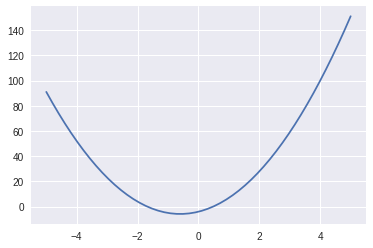

In [7]:
f = lambda x: 5 * x**2 + 6 * x - 4
x = np.linspace(-5, 5, 50)
y = f(x)
plt.plot(x, y)

In [18]:
x_min, f_min = simulatedAnnealing(f, -5, 5, 10, 0.001, 0.1)
print('Minimum found: state = {}, E = {}'.format(x_min, f_min))

Minimum found: state = -0.5957411989856904, E = -5.799909313069603


Аналитический минимум: $x_{min} = -\frac{3}{5}$, $f(x_{min}) = -\frac{29}{5} $, что с хорошей точностью совпадает с полученным отжигом результатом.

Исследуем поведение отжига на более сложной функции:

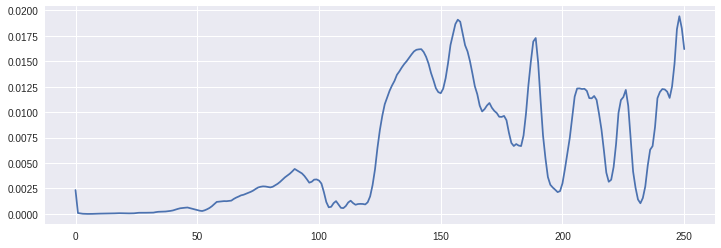

In [32]:
# значение функции задано набором точек
Y = np.load('earr.npy')
fig = plt.figure(figsize=(12,4))
plt.plot(Y)

In [27]:
def F(x):
    index = int(x)
    return Y[index]

Переберем несколько наборов параметров:
* $T_0 = [100, 10, 1]$
* $T_f = [0.01, 0.001, 0.0001, 0.00001]$
* $\alpha = [1, 0.1, 0.01]$

In [52]:
x_mins = np.zeros((3, 4, 3))
F_mins = np.zeros((3, 4, 3))
for i, init_T in enumerate([100, 10, 1]):
    for j, end_T in enumerate([0.01, 0.001, 0.0001, 0.00001]):
        for k, alpha in enumerate([1, 0.1, 0.01]):
            x_min, F_min = simulatedAnnealing(F, 0, 251, init_T, end_T, alpha)
            x_mins[i, j, k] = x_min
            F_mins[i, j, k] = F_min

Отобразим полученные результаты на графике функции:

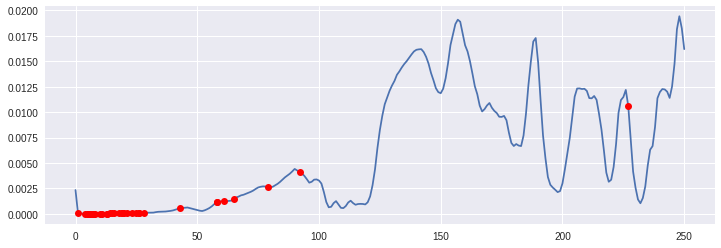

In [55]:
fig = plt.figure(figsize=(12,4))
plt.plot(Y)
plt.plot(list(map(int, x_mins.ravel())), Y[list(map(int, x_mins.ravel()))], 'ro')

Посмотрим на отдельные зависимости:

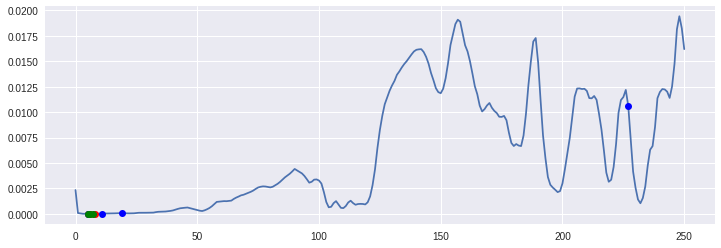

In [63]:
fig = plt.figure(figsize=(12,4))
plt.plot(Y)
plt.plot(list(map(int, x_mins[:, 3, 2])), Y[list(map(int, x_mins[:, 3, 2]))], 'ro')
plt.plot(list(map(int, x_mins[2, :, 2])), Y[list(map(int, x_mins[2, :, 2]))], 'bo')
plt.plot(list(map(int, x_mins[2, 3, :])), Y[list(map(int, x_mins[2, 3, :]))], 'go')

Видно, что качество найденного решения сильно зависит от конечной температуры, и слабо - от начальной и коэффициента альфа(они влияют на время выполнения, т.к. от них зависит итоговое количество итераций).